In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os


In [ ]:
# os.chdir("D:\\umyma\\Internship 10Pearls\\AQI_Predictor")
# os.listdir()

['.env',
 '.git',
 '.github',
 'app',
 'catboost_info',
 'data',
 'LICENSE',
 'models',
 'notebooks',
 'predictions',
 'README.md',
 'requirements.txt',
 'shap_plots',
 'src',
 'test.csv']

In [3]:
# Loading the dataset
merged_df=pd.read_csv("notebooks/bwpData.csv")
merged_df.head(),merged_df.tail(),merged_df.shape

(   Unnamed: 0                  timestamp  temperature_2m  \
 0        3066  2025-05-03 00:00:00+00:00           27.40   
 1        4055  2025-05-03 01:00:00+00:00           27.50   
 2        3368  2025-05-03 02:00:00+00:00           28.55   
 3        4101  2025-05-03 03:00:00+00:00           30.20   
 4        3772  2025-05-03 04:00:00+00:00           32.25   
 
    relative_humidity_2m  wind_speed_10m  pressure_msl  precipitation   pm10  \
 0             50.283356       11.616627        1004.6            0.0  255.2   
 1             58.356834        9.396275        1005.2            0.0  316.6   
 2             55.930695        9.743304        1005.6            0.0  321.3   
 3             50.849490        7.640994        1005.8            0.0  459.1   
 4             44.824660        4.755544        1005.9            0.0  464.7   
 
    pm2_5  carbon_monoxide  ...  hour  day_of_week  day  month  pm25_lag1  \
 0   82.7            411.0  ...     0            5    3      5      108.7

In [4]:
# Checking  missing values for each column 
merged_df.isna().sum()
#no missing values for any column

Unnamed: 0              0
timestamp               0
temperature_2m          0
relative_humidity_2m    0
wind_speed_10m          0
pressure_msl            0
precipitation           0
pm10                    0
pm2_5                   0
carbon_monoxide         0
nitrogen_dioxide        0
sulphur_dioxide         0
ozone                   0
hour                    0
day_of_week             0
day                     0
month                   0
pm25_lag1               0
pm25_lag6               0
pm25_lag24              0
pm25_ma6                0
pm25_ma24               0
pm25_change_1hr         0
dtype: int64

In [5]:
#checking for duplicate timestamps
merged_df["timestamp"].duplicated().sum()
#no duplicate timestamps


np.int64(0)

In [7]:
merged_df.head()
merged_df.tail()

,Unnamed: 0,timestamp,temperature_2m,relative_humidity_2m,wind_speed_10m,pressure_msl,precipitation,pm10,pm2_5,carbon_monoxide,...,hour,day_of_week,day,month,pm25_lag1,pm25_lag6,pm25_lag24,pm25_ma6,pm25_ma24,pm25_change_1hr
6736,6736,2026-02-10 03:00:00+00:00,14.7,85.0,12.0,1017.1,0.0,53.2,48.7,562.0,...,3,1,10,2,45.4,60.3,41.1,46.650001,73.412500,3.299999
6737,6737,2026-02-10 05:00:00+00:00,20.1,62.0,15.9,1018.3,0.0,51.9,45.3,551.0,...,5,1,10,2,48.7,49.5,82.0,45.950001,71.883333,-3.400001
6738,6738,2026-02-10 07:00:00+00:00,22.9,54.0,17.1,1017.5,0.0,47.7,40.3,543.0,...,7,1,10,2,45.3,46.4,106.9,44.933334,69.108333,-4.999999
6739,6739,2026-02-10 09:00:00+00:00,24.5,46.0,16.3,1015.9,0.0,42.7,35.9,553.0,...,9,1,10,2,40.3,44.7,127.6,43.466667,65.287500,-4.399999
6740,6740,2026-02-10 11:00:00+00:00,23.8,45.0,17.1,1015.8,0.0,41.8,35.7,571.0,...,11,1,10,2,35.9,45.2,135.5,41.883334,61.129167,-0.200002


In [8]:
merged_df.shape

(6741, 23)

In [ ]:
# Summary stats
# merged_df.info()
# merged_df.describe()

# hourly granularity + no -ve vals
print(merged_df.columns)

merged_df.columns

Index(['timestamp', 'temperature_2m', 'relative_humidity_2m', 'wind_speed_10m',
       'pressure_msl', 'precipitation', 'pm10', 'pm2_5', 'carbon_monoxide',
       'nitrogen_dioxide', 'sulphur_dioxide', 'ozone', 'hour', 'day_of_week',
       'day', 'month', 'pm25_lag1', 'pm25_lag6', 'pm25_lag24', 'pm25_ma6',
       'pm25_ma24', 'pm25_change_1hr'],
      dtype='object')


Index(['timestamp', 'temperature_2m', 'relative_humidity_2m', 'wind_speed_10m',
       'pressure_msl', 'precipitation', 'pm10', 'pm2_5', 'carbon_monoxide',
       'nitrogen_dioxide', 'sulphur_dioxide', 'ozone', 'hour', 'day_of_week',
       'day', 'month', 'pm25_lag1', 'pm25_lag6', 'pm25_lag24', 'pm25_ma6',
       'pm25_ma24', 'pm25_change_1hr'],
      dtype='object')

In [17]:
# statistical summary
merged_df.describe().T

,count,mean,std,min,25%,50%,75%,max
temperature_2m,6741.0,27.462991,8.976864,2.950000,21.400000,29.600000,33.800000,46.250000
relative_humidity_2m,6741.0,53.872095,19.982987,8.783448,38.966396,54.000000,68.178375,100.000000
wind_speed_10m,6741.0,8.126273,4.319946,0.000000,5.094350,7.452086,10.674773,29.570992
pressure_msl,6741.0,1006.349405,13.743896,860.419250,998.700000,1004.200000,1015.200000,1134.263300
precipitation,6741.0,0.015873,0.249397,0.000000,0.000000,0.000000,0.000000,10.600000
pm10,6741.0,82.131795,57.481935,1.600000,44.600000,69.200000,103.400000,573.700000
pm2_5,6741.0,51.758332,36.297740,1.500000,27.800000,41.300000,62.600000,282.200000
carbon_monoxide,6741.0,709.295827,644.714845,124.000000,283.833680,486.000000,879.000000,4746.000000
nitrogen_dioxide,6741.0,12.291647,12.587028,0.000000,3.000000,8.500000,16.600000,69.500000
sulphur_dioxide,6741.0,8.130910,6.318742,0.300000,3.500000,6.300000,11.100000,49.500000


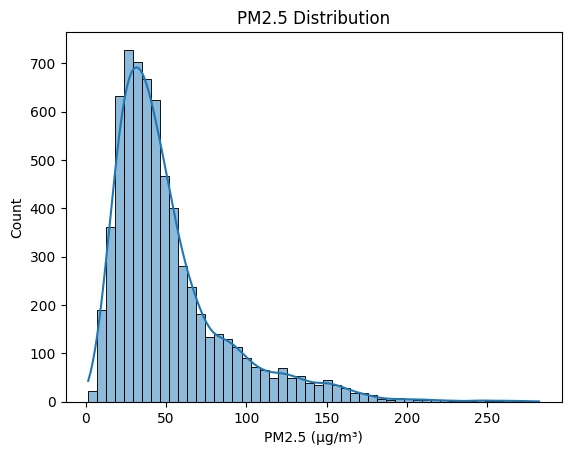

In [18]:
# pm2.5 distributions
sns.histplot(merged_df["pm2_5"], bins=50, kde=True)
plt.title("PM2.5 Distribution")
plt.xlabel("PM2.5 (µg/m³)")
plt.show()


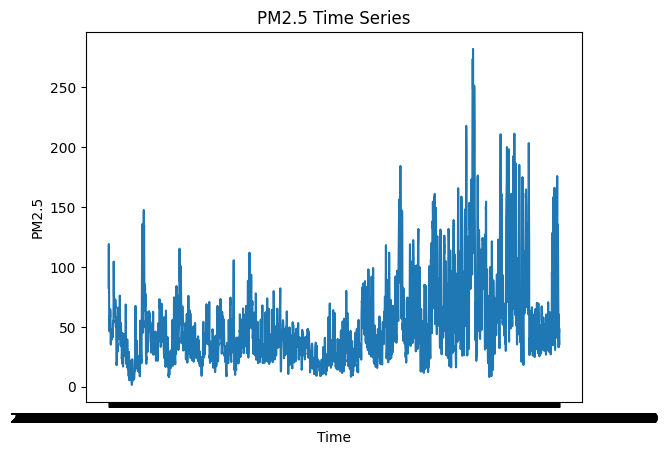

In [20]:
# pm2.5 over time
plt.plot(merged_df["timestamp"], merged_df["pm2_5"])
plt.title("PM2.5 Time Series")
plt.xlabel("Time")
plt.ylabel("PM2.5")
plt.show()

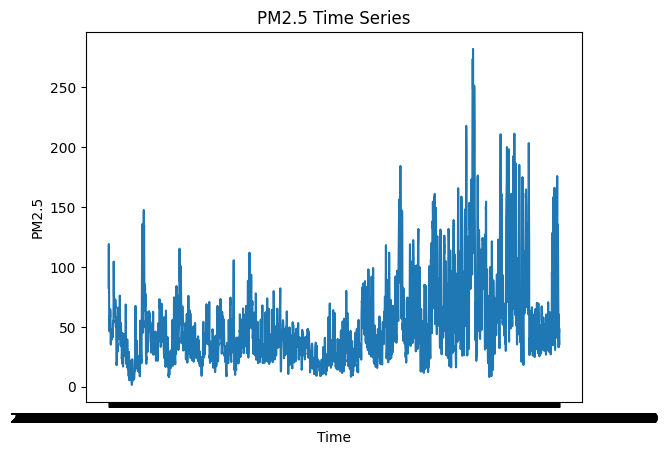

In [21]:
hourly=merged_df.groupby("hour",as_index=False)["pm2_5"].mean()
plt.plot(merged_df["timestamp"], merged_df["pm2_5"])
plt.title("PM2.5 Time Series")
plt.xlabel("Time")
plt.ylabel("PM2.5")
plt.show()

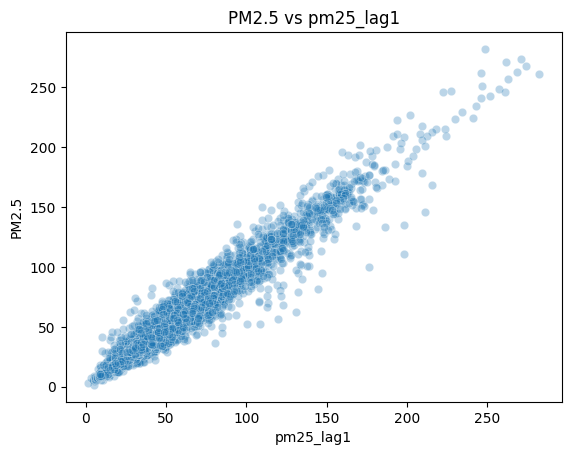

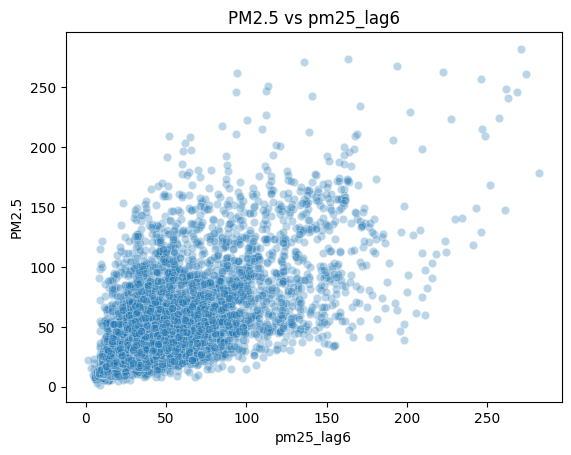

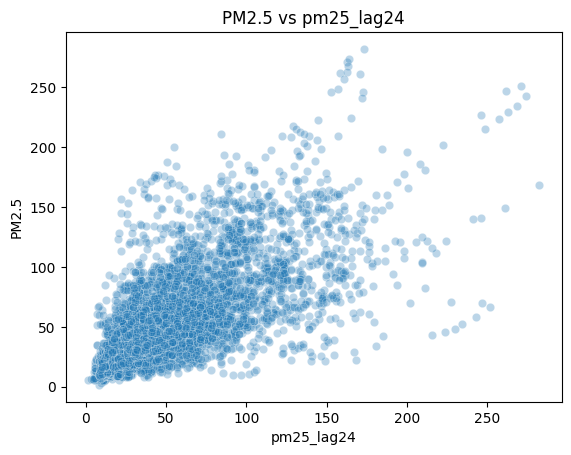

In [22]:
# lag features validation
lag_features = [
    "pm25_lag1",
    "pm25_lag6",
    "pm25_lag24"
]

for col in lag_features:
    sns.scatterplot(x=merged_df[col], y=merged_df["pm2_5"], alpha=0.3)
    plt.title(f"PM2.5 vs {col}")
    plt.xlabel(col)
    plt.ylabel("PM2.5")
    plt.show()


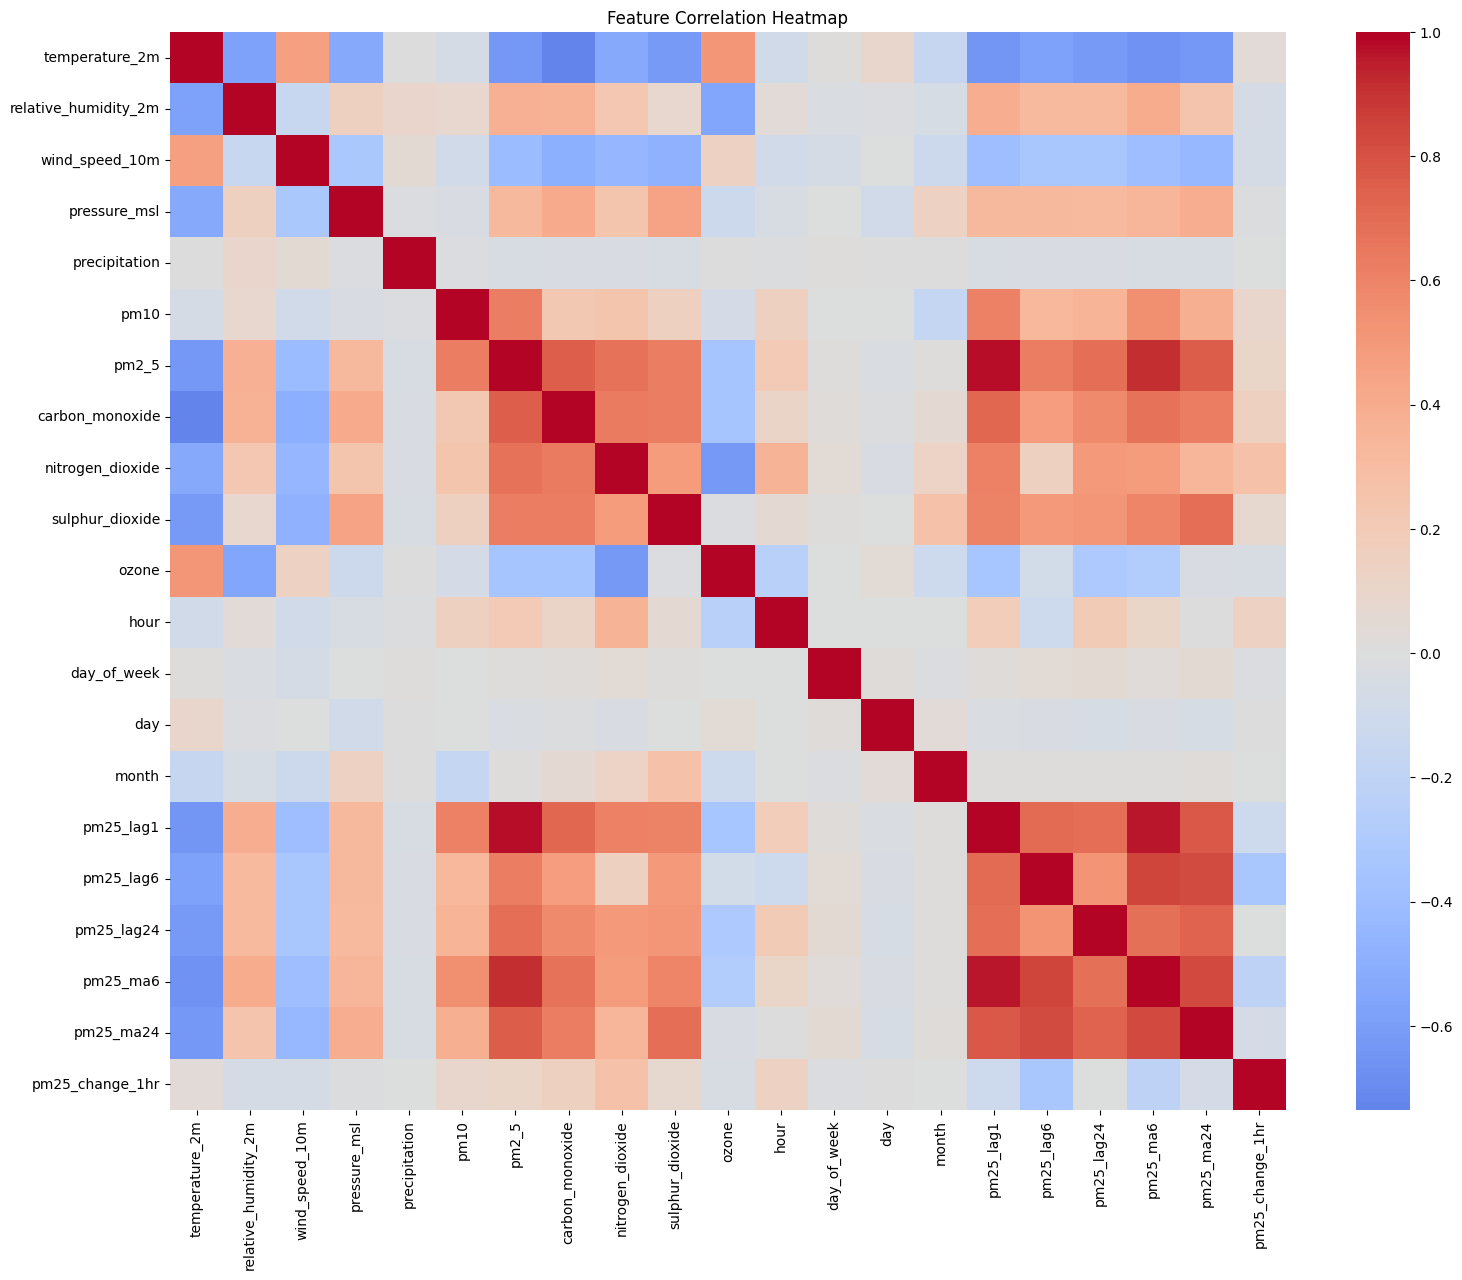

In [23]:
# Correlation Heatmap
numeric_df = merged_df.select_dtypes(include="number")

plt.figure(figsize=(18, 14))
sns.heatmap(
    numeric_df.corr(),
    cmap="coolwarm",
    center=0
)
plt.title("Feature Correlation Heatmap")
plt.show()

Key Observations:

1: PM2.5 is strongly correlated with lag features, pm10, co and no2

2: Weather effects:

    a) Humidity → positive relation
    b) Temperature → negative relation
    c) Wind speed → dispersion effect
    
3: Some features are noisy or weak

In [24]:
# target correlation ranking
numeric_df.corr()["pm2_5"].sort_values(ascending=False)


pm2_5                   1.000000
pm25_lag1               0.976159
pm25_ma6                0.915028
pm25_ma24               0.758332
carbon_monoxide         0.753055
pm25_lag24              0.691701
nitrogen_dioxide        0.668484
pm25_lag6               0.629971
pm10                    0.629540
sulphur_dioxide         0.623411
relative_humidity_2m    0.380339
pressure_msl            0.324686
hour                    0.212226
pm25_change_1hr         0.109736
day_of_week             0.016088
month                   0.011599
day                    -0.028154
precipitation          -0.039827
ozone                  -0.355105
wind_speed_10m         -0.411422
temperature_2m         -0.638774
Name: pm2_5, dtype: float64

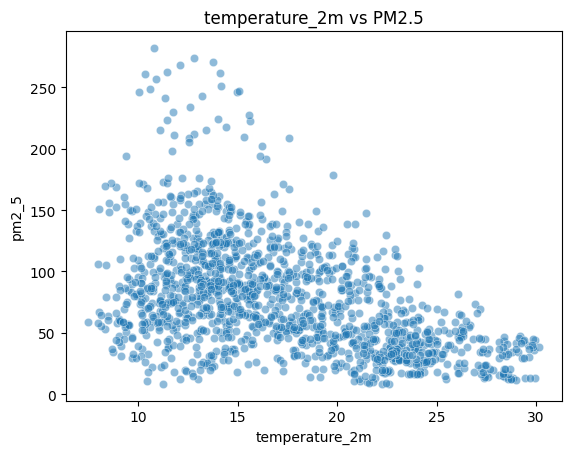

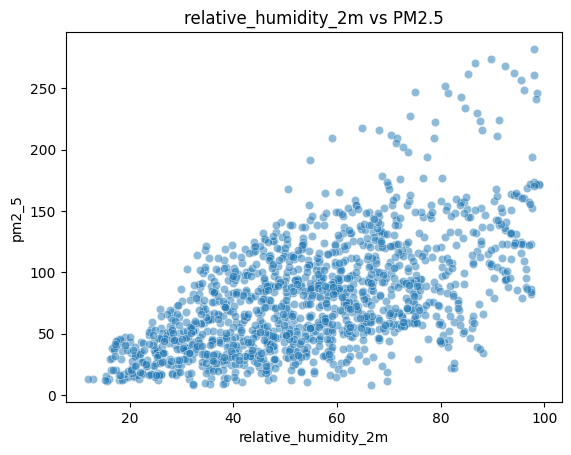

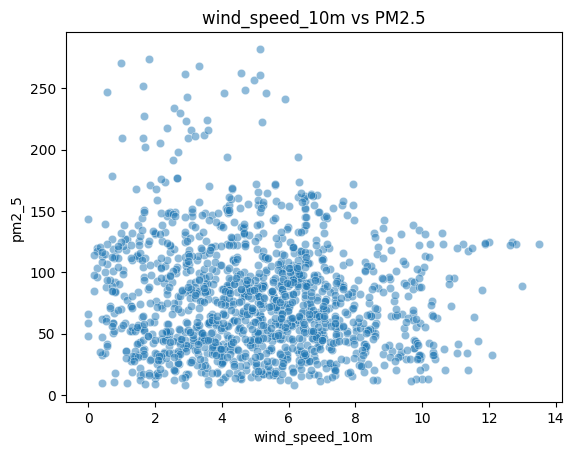

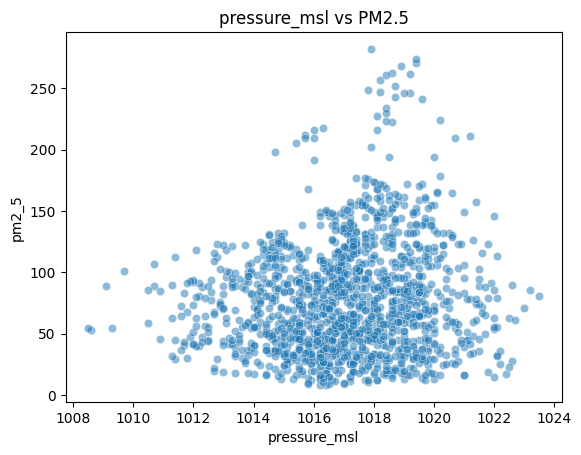

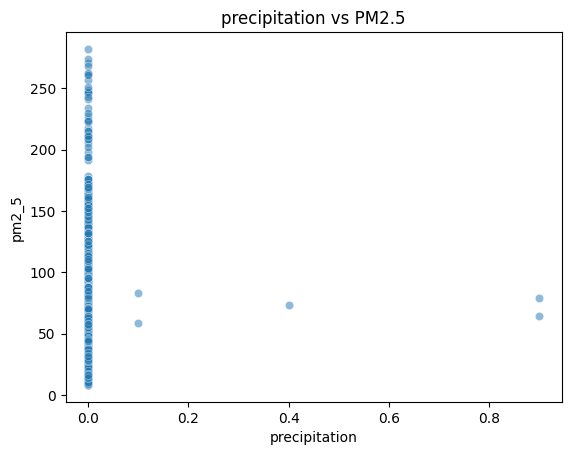

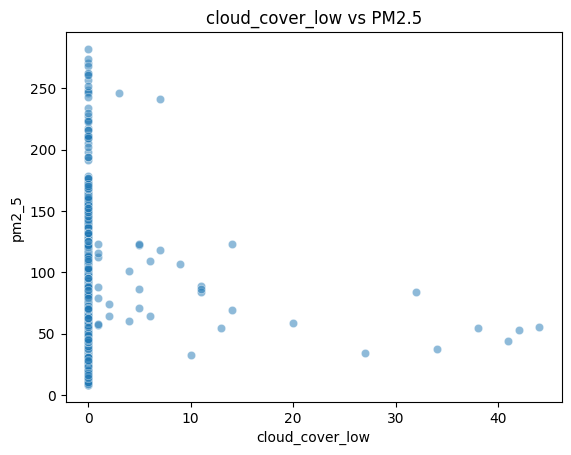

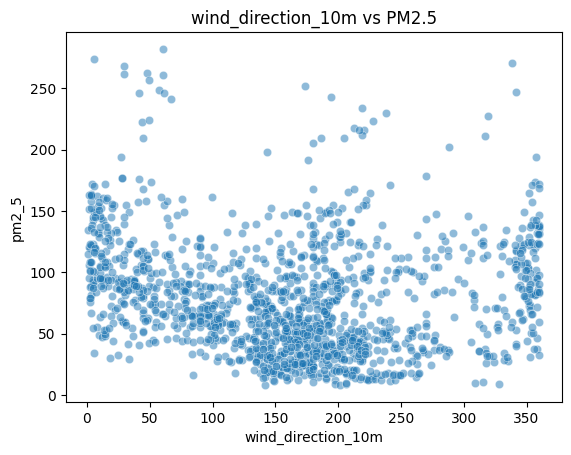

In [13]:
# Checking feature wise relation w target

# Weather Variables
weather_features = [
    "temperature_2m",
    "relative_humidity_2m",
    "wind_speed_10m",
    "pressure_msl",
    "precipitation",
    "cloud_cover_low",
    "wind_direction_10m"
]
for col in weather_features:
    sns.scatterplot(x=col, y="pm2_5", data=merged_df, alpha=0.5)
    plt.title(f"{col} vs PM2.5")
    plt.show()

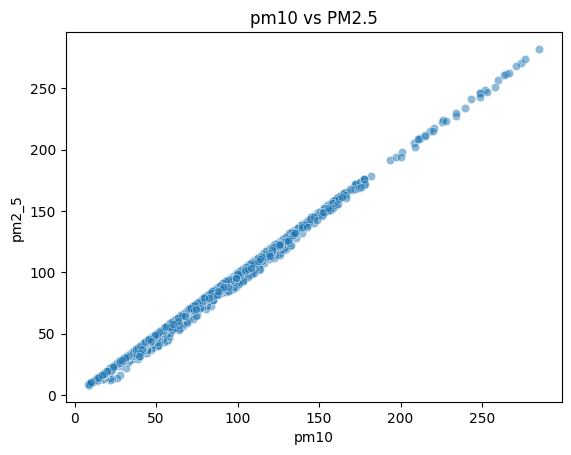

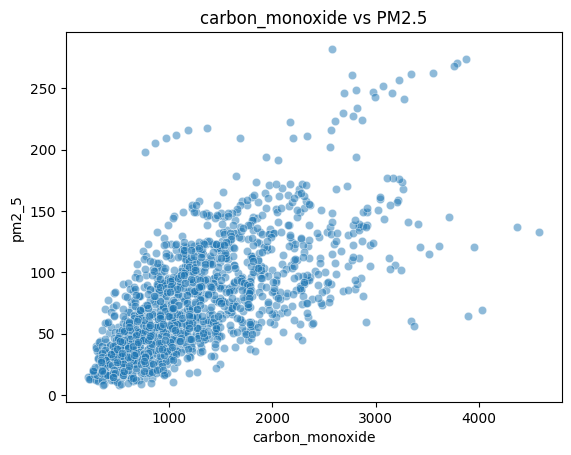

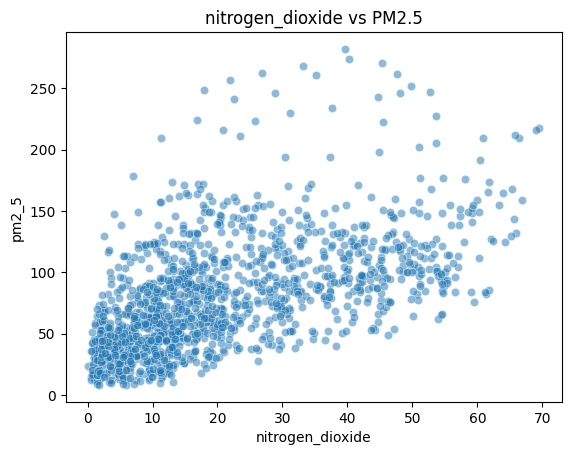

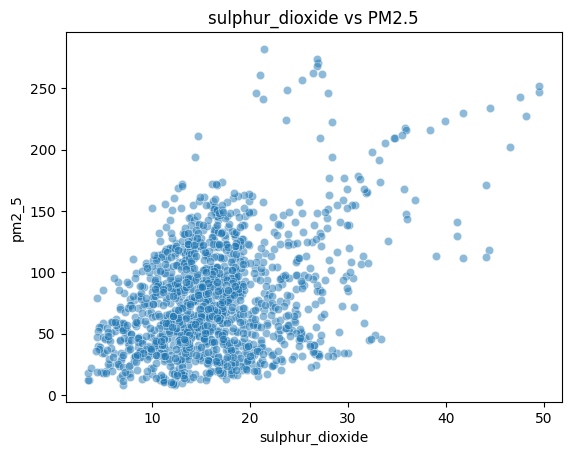

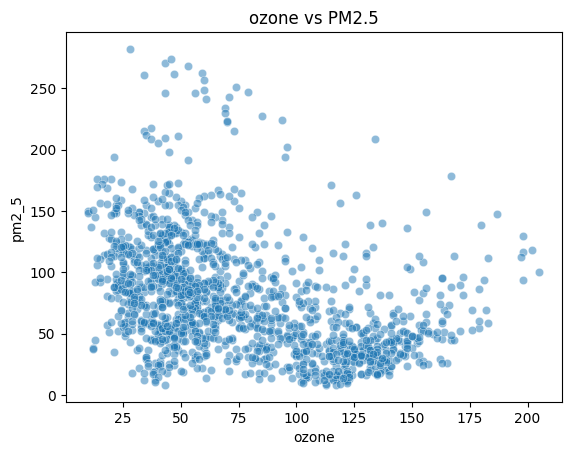

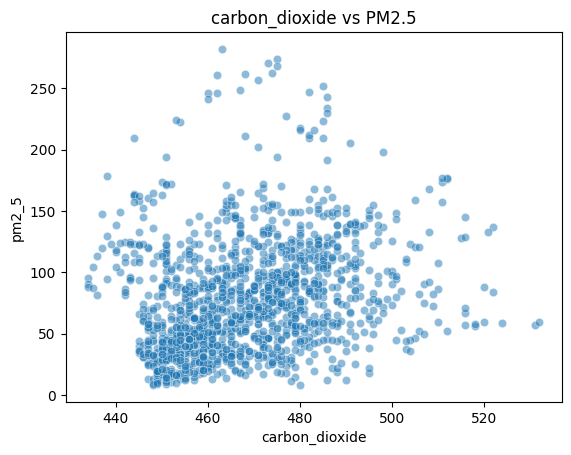

In [14]:
# Pollutants

pollutants = [
    "pm10",
    "carbon_monoxide",
    "nitrogen_dioxide",
    "sulphur_dioxide",
    "ozone",
    "carbon_dioxide"
]
for col in pollutants:
    sns.scatterplot(x=col, y="pm2_5", data=merged_df, alpha=0.5)
    plt.title(f"{col} vs PM2.5")
    plt.show()

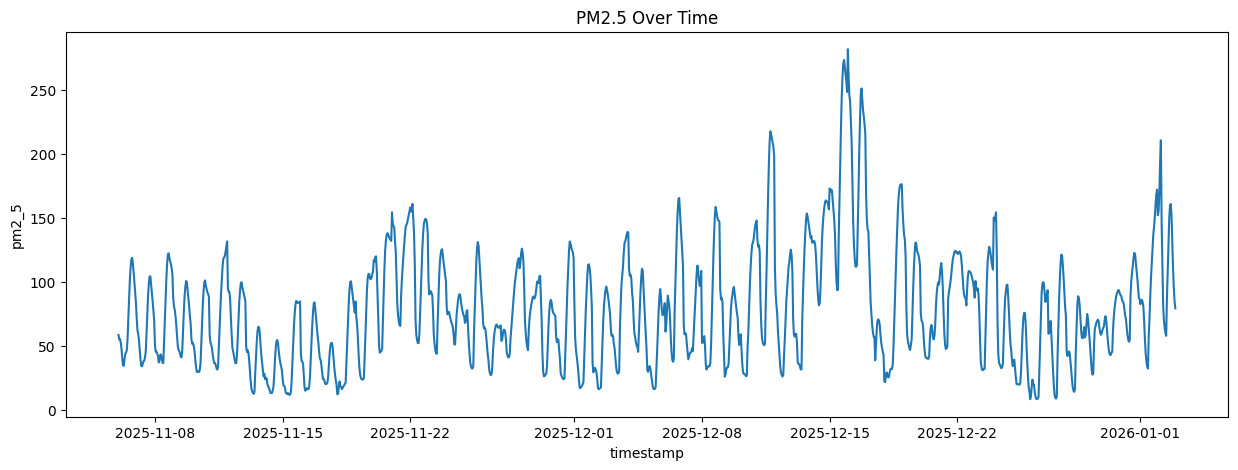

In [15]:
# PM2.5 over time
plt.figure(figsize=(15,5))
sns.lineplot(x='timestamp', y='pm2_5', data=merged_df)
plt.title('PM2.5 Over Time')
plt.show()

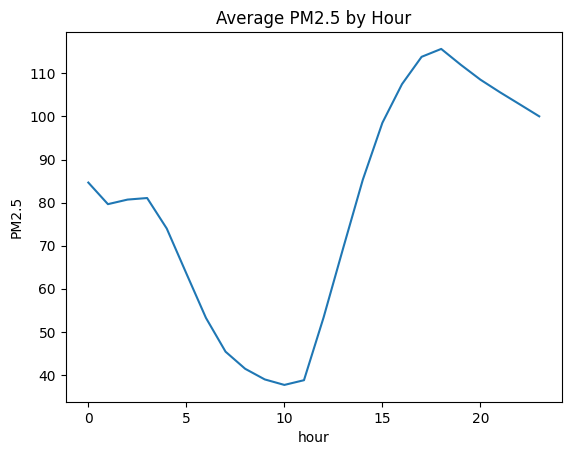

In [16]:
# Hourly trend
merged_df.groupby("hour")["pm2_5"].mean().plot()
plt.title("Average PM2.5 by Hour")
plt.ylabel("PM2.5")
plt.show()

In [17]:
# Validating lag features
merged_df[["pm2_5", "pm25_lag1", "pm25_lag6", "pm25_lag24"]].corr()

,pm2_5,pm25_lag1,pm25_lag6,pm25_lag24
pm2_5,1.000000,0.969217,0.470275,0.618076
pm25_lag1,0.969217,1.000000,0.585086,0.614070
pm25_lag6,0.470275,0.585086,1.000000,0.307042
pm25_lag24,0.618076,0.614070,0.307042,1.000000


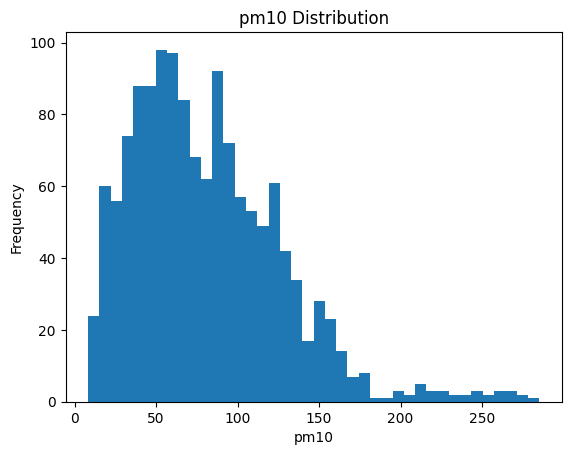

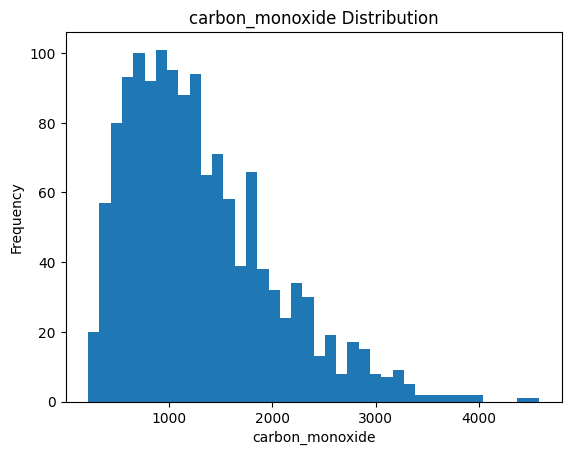

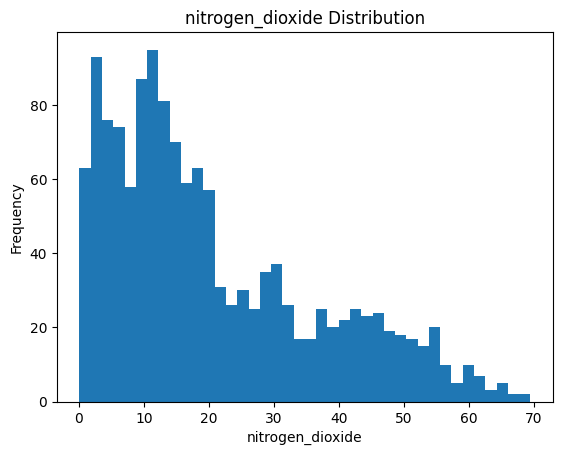

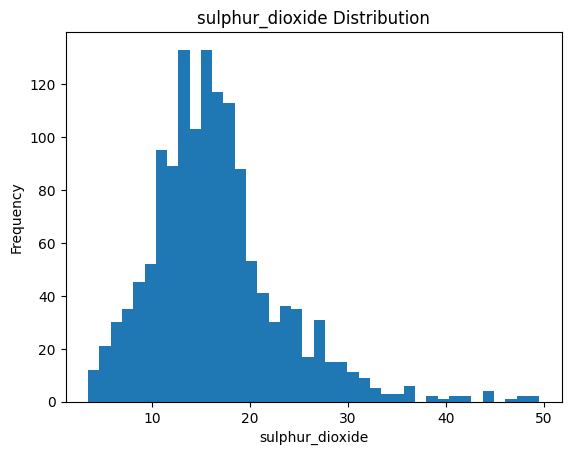

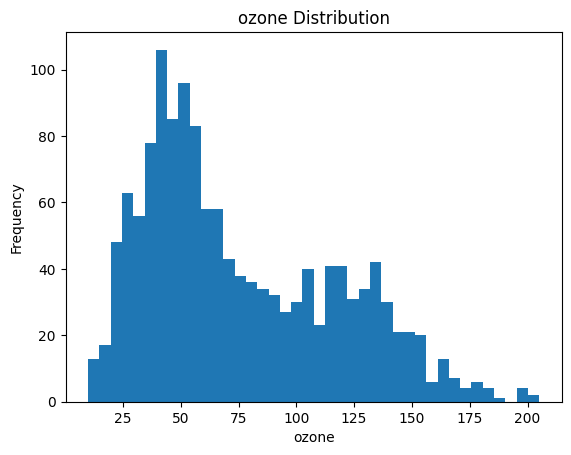

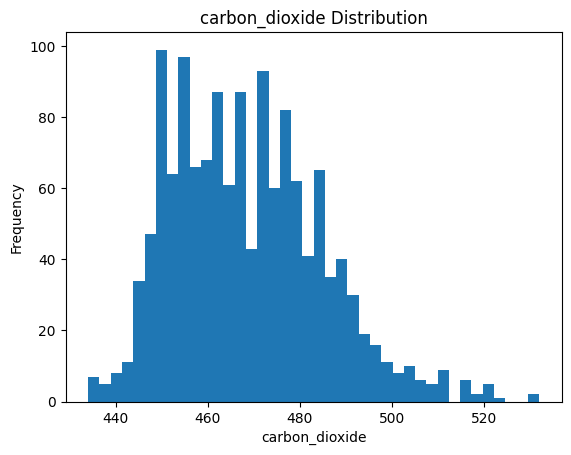

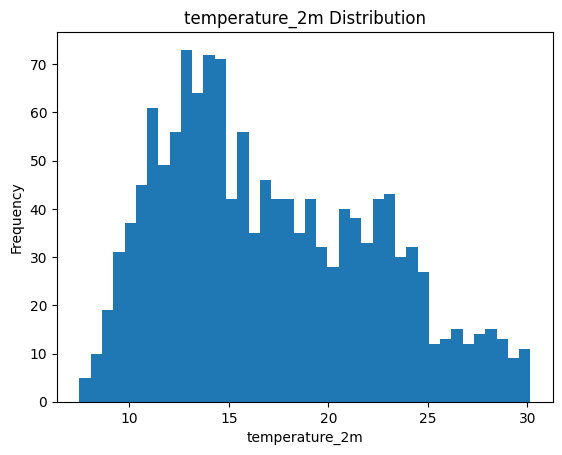

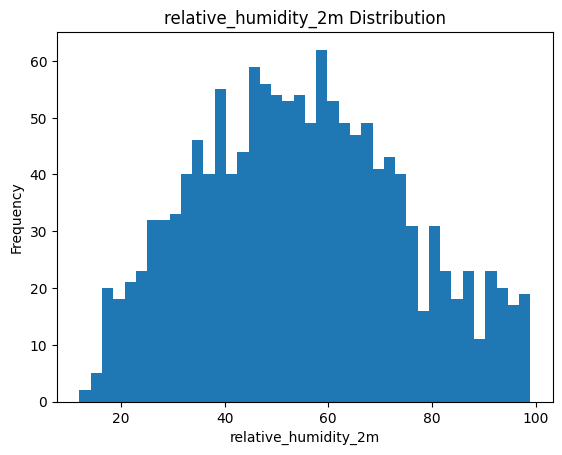

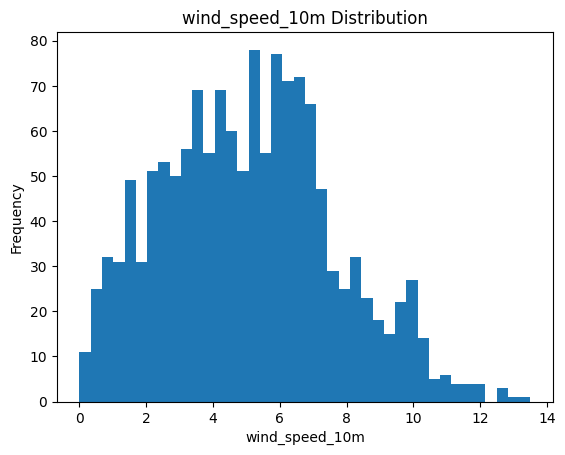

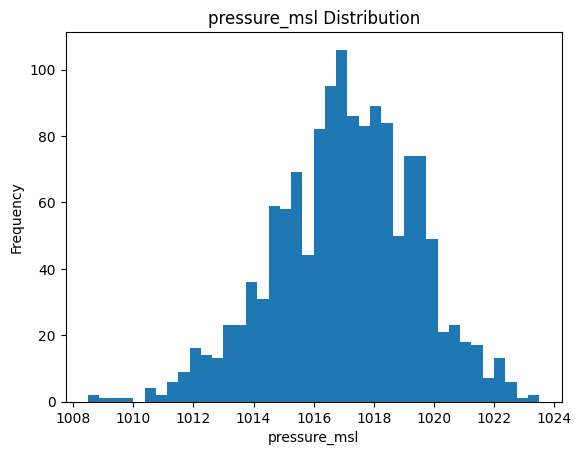

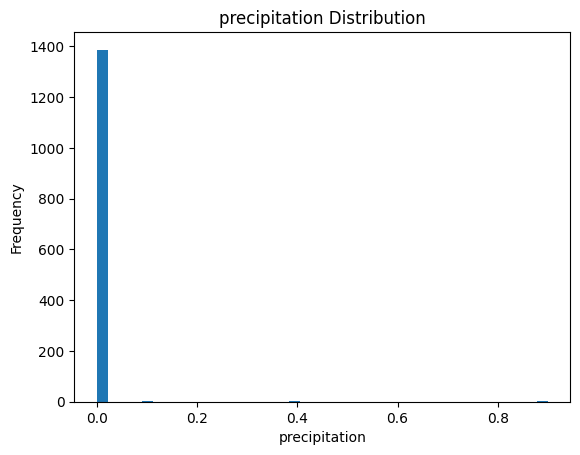

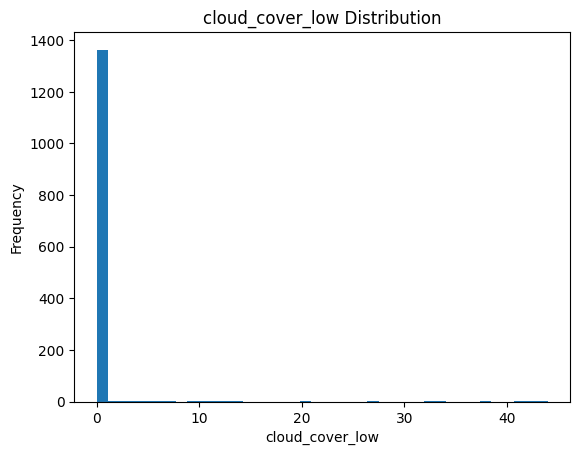

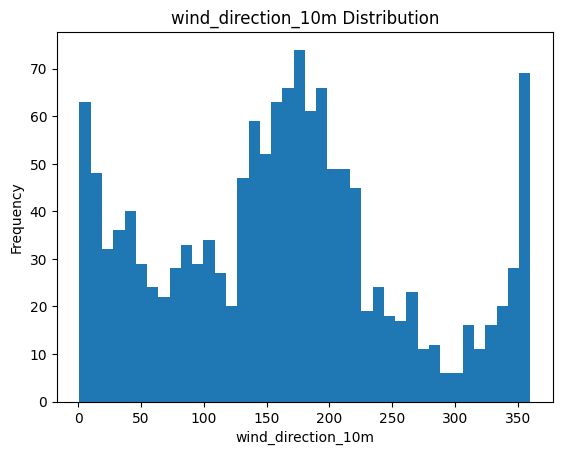

In [18]:
def plot_hist(df, col, bins=40):
    plt.hist(df[col], bins=bins)
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.title(f'{col} Distribution')
    plt.show()
for col in pollutants + weather_features:
    plot_hist(merged_df, col)    

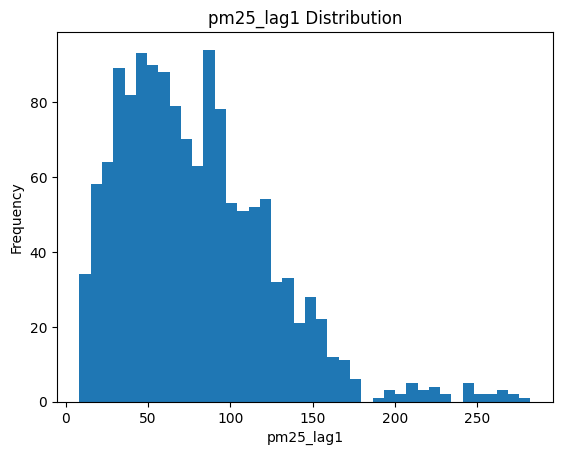

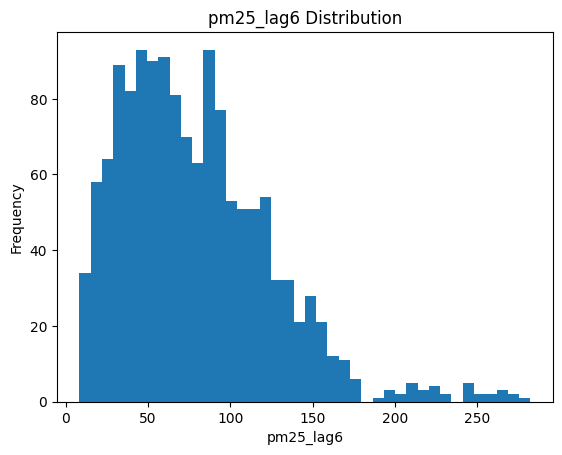

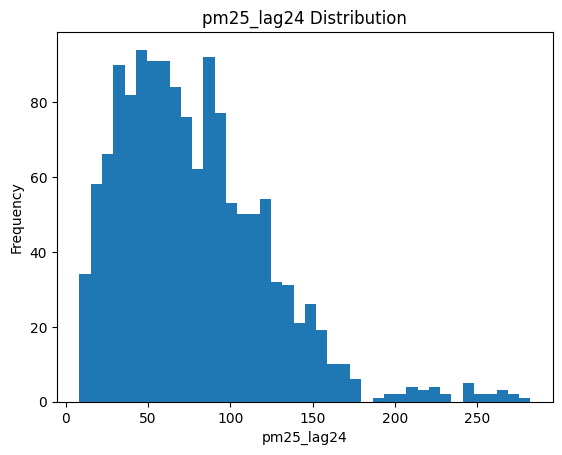

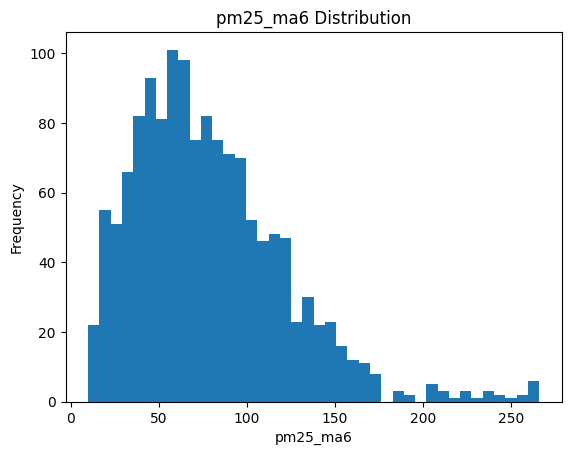

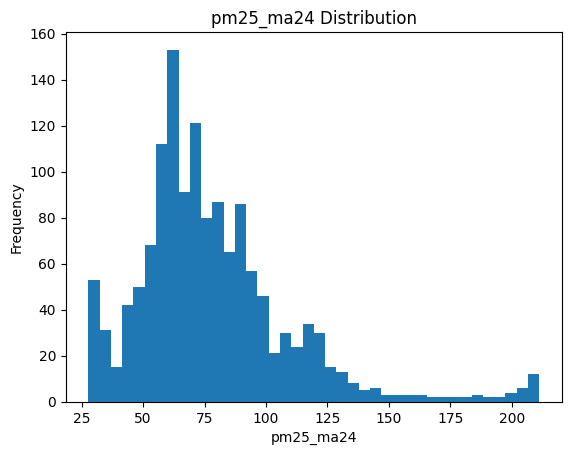

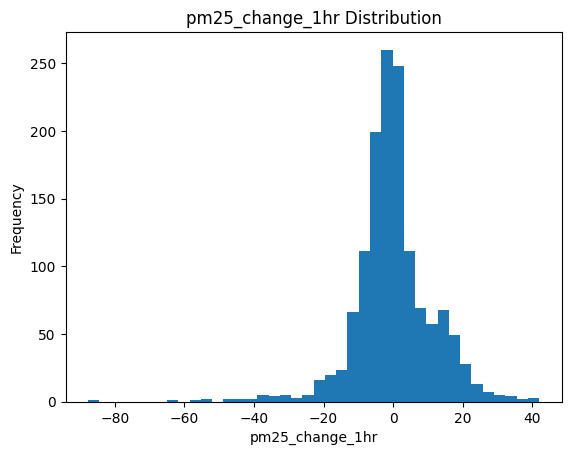

In [20]:
additional_features=['pm25_lag1', 'pm25_lag6', 'pm25_lag24', 'pm25_ma6', 'pm25_ma24', 'pm25_change_1hr']
for col in additional_features:
    plot_hist(merged_df,col)
                     

In [21]:
from scipy import stats
import numpy as np

z_scores = np.abs(stats.zscore(merged_df[['pm2_5', 'pm10', 'carbon_monoxide']]))
outliers = (z_scores > 3).any(axis=1)
print("Number of outlier rows:", outliers.sum())

Number of outlier rows: 31


# Final Feature Selection
based on histogram and scatter plot analysis, no strong
relationships were observed between the target and the following features:

a) precipitation
b) cloud_cover_low
c) wind_direction_low
d) day_of_week
e) month

Therefore, these features will be dropped from the dataset